In [35]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 9999)
pd.set_option('display.max_rows', 9999)

### Import Trades from file generated by code and create Prices dataframe

In [59]:
# Read generated buys
trades = pd.read_feather('../output/trades.feather')
business_days = set(trades['just_date'].unique())

### Create DataFrames of Buys and Sells
#### Buys

In [60]:
def extract_buys(df, pair_of_signals, buy_date, how_much):
    
    # Create empty list to store results
    buys_list = []
    
    # Columns
    columns_list = ['symbol', 'date', 'price', 'order_type', 'shares', 'total', 'strategy']
    
    # Empty dataframe
    empty_df = pd.DataFrame([[0,0,0,0,0,0]], columns = ['symbol', 'date', 'price', 'order_type', 'shares', 'total'])
    
    # Loop through different strategies
    for buy_signal, sell_signal in pair_of_signals:

        # Create dataframe with buys
        buys = df[(df['just_date'] == buy_date) 
                    & (df[buy_signal] == True)
                    & (df[sell_signal] != True)][['symbol', 'just_date', 'close_price_x']]

        # Create some other columns
        buys['order_type'] = 'buy'
        buys['shares'] = how_much / buys['close_price_x']
        buys['total'] = buys['shares'] * buys['close_price_x']
        buys['strategy'] = buy_signal
       
        # If length is zero then create empty record
        if len(buys) == 0:
            buys_none = empty_df
            buys_none['strategy'] = buy_signal
            buys_list.append(buys_none.values.tolist()[0])
        
        # Else then append buys
        else:
            buys.columns = columns_list
            buys_list.append(buys.values.tolist()[0])
    
    # Transform list into a Dataframe
    buys_df = pd.DataFrame(buys_list, columns = columns_list)
    
    return buys_df

### Sells

In [61]:
def extract_sells(trades, date, sell_signal):
    # Search for the sell_signal on a given day
    sells = trades[(trades['just_date'] == date) 
                & (trades[sell_signal] == True)][['symbol', 'just_date', 'close_price_x']]
    
    # Create Column with order type
    sells['order_type'] = 'sell'
    
    # Rename a columns
    sells.columns = ['symbol', 'sell_date', 'price', 'order_type']
    
    return sells

### Loop Through Days
Logic:
- See if there are any buys on that day and add to holdings_df if that's the case.
- See if there are any sells using the sell_signal and limits (max_loss and max_holdings).
- If you have sells, then remove them from holdings and add to rgl_df.

In [62]:
# Define Min, Max and Moving Dates
min_date = trades['just_date'].min()
max_date = trades['just_date'].max()
number_of_days = (max_date - min_date).days + 1
count = 1

# Result Lists
holdings_list = []
rgl_list = []

# The moving date gives sells/buys on a given day.
moving_date = min_date

# List of buy signals to be analyzed
pair_of_signals = [ ('buy_signal?1', 'sell_signal?1'),
                    ('buy_signal?2', 'sell_signal?2'),
                    ('buy_signal?3', 'sell_signal?3'),
                    ('buy_signal?4', 'sell_signal?4'),
                    ('buy_signal?5', 'sell_signal?5')]

# Max loss and holdings
max_loss = -0.5
max_holdings = 30

# calendar
calendar = []

# While moving date is less or equal to max_date
while moving_date <= max_date:
    
    # Add to calendar
    calendar.append(moving_date)
    
    # Start tracking time
    start_time = time.time()
    
    # If it's the first date, the process is different, because holdings and rgl need to be created yet
    if moving_date == min_date:
        
        # Figure out buys
        buys = extract_buys(trades, pair_of_signals=pair_of_signals, buy_date=moving_date, how_much=100)
        
        # Create holdings
        holdings_df = buys[['strategy', 'date', 'symbol', 'price', 'shares', 'total']]
        holdings_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis']
        
        # As of Date and close_price columns
        holdings_df['as_of_date'] = moving_date
        holdings_df['day_close_price'] = 0
        
        # Convert symbols to string to avoid merging problems in the future
        holdings_df['symbol'] = holdings_df['symbol'].astype(str)
        
        # Holdings append
        holdings_list.append(holdings_df.values.tolist())
        
        # Create RGL
        rgl_df = holdings_df.copy()
        rgl_list.append(rgl_df.values.tolist())
                
    # If it's not the first day:
    else:
        
        # Create prices dataframe from trades
        prices = trades[trades['just_date'] == moving_date][['symbol', 'close_price_x']]
        prices.columns = ['symbol', 'day_close_price']
        
        # Get Previous Day's Holdings and store the number of securities held on that day
        
        #previous_holdings = temp_holdings[temp_holdings['as_of_date'] == previous_day]
        previous_holdings = pd.DataFrame(holdings_list[-1])
        previous_holdings = previous_holdings.iloc[:,0:6]
        previous_holdings.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares',
                                       'cost_basis']
        #previous_holdings = previous_holdings.drop('day_close_price', axis=1)
        #previous_holdings.drop(['as_of_date'], axis=1, inplace=True)
        
        # Create Temporary RGL List to Append results from each strategy
        rgl_temp = []
        holdings_temp = []
        
        # Loop through different strategies
        for buy_signal, sell_signal in pair_of_signals:   
            
            # Strategy Holdings
            strategy_holdings = previous_holdings[previous_holdings['strategy'] == buy_signal]
            
            # Check the number of Holdings symbols in a given strategy
            number_of_symbols = len(strategy_holdings['symbol'].unique())
        
            # Figure out sells and create list of symbols with sell signals
            sells = extract_sells(trades, moving_date, sell_signal=sell_signal)
            sold_symbols = set(sells['symbol'])
        
            # Remove sells from Previous Day's Holdings
            holdings_no_sells = strategy_holdings[~strategy_holdings['symbol'].isin(sold_symbols)]
        
            # Do the following with the securities that were left (only in business days)
            if moving_date in business_days:
        
                # Create new sell signals based on max_loss and max_holdings
                # Calculate % gain
                stop_loss_sells = pd.merge(holdings_no_sells, prices, on='symbol', how='left')
                stop_loss_sells['market_value'] = stop_loss_sells['shares'] * stop_loss_sells['day_close_price']
                stop_loss_sells['%_gain'] = (stop_loss_sells['market_value'] / stop_loss_sells['cost_basis']) - 1
            
                # Create column with date and remove 0's from sells
                stop_loss_sells['just_date'] = moving_date
                stop_loss_sells = stop_loss_sells[stop_loss_sells['buy_date'] != 0]
            
                # If sell signals were generated from this, then do the following
                if len(stop_loss_sells) > 0:
                
                    # Calculate the number of Holding Days, which is the difference between buy_date and just_date
                    stop_loss_sells['holding_days'] = (stop_loss_sells['just_date'] - stop_loss_sells['buy_date'])
                    stop_loss_sells['holding_days'] = stop_loss_sells['holding_days'].dt.days
                
                    # Create Sell Signal if % gain is below max_loss OR holding_days is greater then max_holdings
                    stop_loss_sells = stop_loss_sells[
                        (stop_loss_sells['%_gain'] < max_loss)
                       |(stop_loss_sells['holding_days'] > max_holdings)][['symbol', 'just_date', 'day_close_price']]
                
                    # Create order_type column and rename columns
                    stop_loss_sells['order_type'] = 'sell'
                    stop_loss_sells.columns = ['symbol', 'sell_date', 'price', 'order_type']

                    # Concatenate new sells with sells generated from sell_signal? 
                    sells = pd.concat([sells, stop_loss_sells])
                
                    # Create list of sold symbols
                    sold_symbols = set(sells['symbol'])

                # Remove sells from Previous Day's Holdings, again. This time including sells from loss and holding limits
                holdings_no_sells = strategy_holdings[~strategy_holdings['symbol'].isin(sold_symbols)]
                
            # Append results into holdings_temp
            [holdings_temp.append(i) for i in holdings_no_sells.values.tolist()]
        
            # Store Realized Gains/Losses in rgl_df only if there are symbols in sold_symbols
            if len(sold_symbols) > 0:

                # Create Dataframe by merging Previous Day's Holdings with sells dataframe
                today_rgl = pd.merge(strategy_holdings, sells, how='inner', on='symbol')

                # Get prices in which the securities were sold
                today_rgl = pd.merge(today_rgl, prices, how='left', on='symbol')

                # Create as of date column and calculate gains and market value
                today_rgl['as_of_date'] = moving_date
                today_rgl['market_value'] = today_rgl['shares'] * today_rgl['day_close_price']
                today_rgl['$_gain'] = today_rgl['market_value'] - today_rgl['cost_basis']
                today_rgl['%_gain'] = (today_rgl['market_value'] / today_rgl['cost_basis']) - 1

                # Add that into master rgl_df
                #rgl_df = pd.concat([rgl_df, today_rgl])
                if len(today_rgl) > 0:
                    rgl_temp.append(today_rgl.values.tolist())
        
        # Append results into rgl_list
        [rgl_list.append(i) for i in rgl_temp]
        
        # Now that sold securities have been removed from holdings, it's time to look for buys
        buys = extract_buys(trades, pair_of_signals=pair_of_signals, buy_date=moving_date, how_much=100)
        buys = buys[['strategy', 'date', 'symbol', 'price', 'shares', 'total']]
        buys.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis']
        
        # Add Buys to holdings
        columns = holdings_no_sells.columns
        holdings_data_frame = [i for i in holdings_temp]
        holdings_no_sells_temp = pd.DataFrame(holdings_data_frame, columns=columns)
        today = pd.concat([holdings_no_sells_temp, buys])
        today = today.drop_duplicates()
        today['as_of_date'] = moving_date
         
        # Number of Symbols in new holdings (Previous Day's minus sells, plus new buys)
        number_of_symbols = len(today['symbol'].unique())
        
        # If you have more than one security (there's a placeholder, so we need more than one)
        # Then pull prices to calculate market value and % gain
        if number_of_symbols > 1:
            today = pd.merge(today, prices, on='symbol', how='left')
            today['market_value'] = today['shares'] * today['day_close_price']
            today['%_gain'] = (today['market_value'] / today['cost_basis']) - 1
        
        # Append with master holdings
        #holdings_df = holdings_df.append(today)
        holdings_list.append(today.values.tolist())
        
        # Completion %
        print(str(round((100 * count / number_of_days),2)) + ' % - ' + str(round(time.time() - start_time, 1)) + ' seconds')
    
    # Previous day becomes moving_date and moving date becomes moving date plus one day
    previous_day = moving_date
    moving_date += timedelta(days=1)
    count += 1

0.17 % - 0.2 seconds
0.25 % - 0.2 seconds
0.33 % - 0.2 seconds
0.41 % - 0.2 seconds
0.5 % - 0.2 seconds
0.58 % - 0.2 seconds
0.66 % - 0.2 seconds
0.74 % - 0.2 seconds
0.83 % - 0.2 seconds
0.91 % - 0.2 seconds
0.99 % - 0.2 seconds
1.07 % - 0.2 seconds
1.16 % - 0.2 seconds
1.24 % - 0.2 seconds
1.32 % - 0.2 seconds
1.4 % - 0.2 seconds
1.49 % - 0.2 seconds
1.57 % - 0.2 seconds
1.65 % - 0.2 seconds
1.74 % - 0.2 seconds
1.82 % - 0.2 seconds
1.9 % - 0.2 seconds
1.98 % - 0.2 seconds
2.07 % - 0.2 seconds
2.15 % - 0.2 seconds
2.23 % - 0.2 seconds
2.31 % - 0.2 seconds
2.4 % - 0.2 seconds
2.48 % - 0.2 seconds
2.56 % - 0.2 seconds
2.64 % - 0.2 seconds
2.73 % - 0.2 seconds
2.81 % - 0.2 seconds
2.89 % - 0.2 seconds
2.98 % - 0.2 seconds
3.06 % - 0.2 seconds
3.14 % - 0.2 seconds
3.22 % - 0.2 seconds
3.31 % - 0.2 seconds
3.39 % - 0.2 seconds
3.47 % - 0.2 seconds
3.55 % - 0.2 seconds
3.64 % - 0.2 seconds
3.72 % - 0.2 seconds
3.8 % - 0.2 seconds
3.88 % - 0.2 seconds
3.97 % - 0.2 seconds
4.05 % - 0.2 secon

31.65 % - 0.2 seconds
31.74 % - 0.3 seconds
31.82 % - 0.3 seconds
31.9 % - 0.3 seconds
31.98 % - 0.3 seconds
32.07 % - 0.3 seconds
32.15 % - 0.2 seconds
32.23 % - 0.2 seconds
32.31 % - 0.2 seconds
32.4 % - 0.3 seconds
32.48 % - 0.3 seconds
32.56 % - 0.3 seconds
32.64 % - 0.3 seconds
32.73 % - 0.2 seconds
32.81 % - 0.2 seconds
32.89 % - 0.3 seconds
32.98 % - 0.3 seconds
33.06 % - 0.3 seconds
33.14 % - 0.3 seconds
33.22 % - 0.3 seconds
33.31 % - 0.2 seconds
33.39 % - 0.2 seconds
33.47 % - 0.3 seconds
33.55 % - 0.3 seconds
33.64 % - 0.2 seconds
33.72 % - 0.2 seconds
33.8 % - 0.3 seconds
33.88 % - 0.2 seconds
33.97 % - 0.2 seconds
34.05 % - 0.3 seconds
34.13 % - 0.2 seconds
34.21 % - 0.3 seconds
34.3 % - 0.3 seconds
34.38 % - 0.3 seconds
34.46 % - 0.2 seconds
34.55 % - 0.2 seconds
34.63 % - 0.3 seconds
34.71 % - 0.3 seconds
34.79 % - 0.2 seconds
34.88 % - 0.3 seconds
34.96 % - 0.3 seconds
35.04 % - 0.2 seconds
35.12 % - 0.2 seconds
35.21 % - 0.3 seconds
35.29 % - 0.3 seconds
35.37 % - 0.3 

62.64 % - 0.3 seconds
62.73 % - 0.3 seconds
62.81 % - 0.2 seconds
62.89 % - 0.2 seconds
62.98 % - 0.3 seconds
63.06 % - 0.3 seconds
63.14 % - 0.3 seconds
63.22 % - 0.3 seconds
63.31 % - 0.2 seconds
63.39 % - 0.2 seconds
63.47 % - 0.2 seconds
63.55 % - 0.3 seconds
63.64 % - 0.3 seconds
63.72 % - 0.3 seconds
63.8 % - 0.3 seconds
63.88 % - 0.3 seconds
63.97 % - 0.2 seconds
64.05 % - 0.2 seconds
64.13 % - 0.3 seconds
64.21 % - 0.3 seconds
64.3 % - 0.2 seconds
64.38 % - 0.3 seconds
64.46 % - 0.3 seconds
64.55 % - 0.2 seconds
64.63 % - 0.2 seconds
64.71 % - 0.3 seconds
64.79 % - 0.3 seconds
64.88 % - 0.3 seconds
64.96 % - 0.2 seconds
65.04 % - 0.3 seconds
65.12 % - 0.2 seconds
65.21 % - 0.2 seconds
65.29 % - 0.2 seconds
65.37 % - 0.2 seconds
65.45 % - 0.2 seconds
65.54 % - 0.3 seconds
65.62 % - 0.3 seconds
65.7 % - 0.2 seconds
65.79 % - 0.2 seconds
65.87 % - 0.3 seconds
65.95 % - 0.3 seconds
66.03 % - 0.2 seconds
66.12 % - 0.2 seconds
66.2 % - 0.2 seconds
66.28 % - 0.2 seconds
66.36 % - 0.2 

93.64 % - 0.3 seconds
93.72 % - 0.3 seconds
93.8 % - 0.3 seconds
93.88 % - 0.3 seconds
93.97 % - 0.3 seconds
94.05 % - 0.2 seconds
94.13 % - 0.2 seconds
94.21 % - 0.3 seconds
94.3 % - 0.3 seconds
94.38 % - 0.3 seconds
94.46 % - 0.2 seconds
94.55 % - 0.3 seconds
94.63 % - 0.2 seconds
94.71 % - 0.2 seconds
94.79 % - 0.3 seconds
94.88 % - 0.2 seconds
94.96 % - 0.2 seconds
95.04 % - 0.2 seconds
95.12 % - 0.2 seconds
95.21 % - 0.2 seconds
95.29 % - 0.2 seconds
95.37 % - 0.3 seconds
95.45 % - 0.3 seconds
95.54 % - 0.3 seconds
95.62 % - 0.3 seconds
95.7 % - 0.3 seconds
95.79 % - 0.2 seconds
95.87 % - 0.2 seconds
95.95 % - 0.3 seconds
96.03 % - 0.3 seconds
96.12 % - 0.3 seconds
96.2 % - 0.3 seconds
96.28 % - 0.3 seconds
96.36 % - 0.2 seconds
96.45 % - 0.2 seconds
96.53 % - 0.3 seconds
96.61 % - 0.3 seconds
96.69 % - 0.3 seconds
96.78 % - 0.3 seconds
96.86 % - 0.2 seconds
96.94 % - 0.2 seconds
97.02 % - 0.2 seconds
97.11 % - 0.3 seconds
97.19 % - 0.3 seconds
97.27 % - 0.3 seconds
97.36 % - 0.3 

## Daily Holdings

In [63]:
data_frame_list = [x for b in holdings_list for x in b]
holdings_df = pd.DataFrame(data_frame_list)
holdings_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis', 'as_of_date', 'day_close_price', 'market_value', '%_gain']
holdings_df.head()


,strategy,buy_date,symbol,cost_per_unit,shares,cost_basis,as_of_date,day_close_price,market_value,%_gain
0,buy_signal?1,0,0,0.0,0.0,0.0,2017-01-25,0.0,NaN,NaN
1,buy_signal?2,0,0,0.0,0.0,0.0,2017-01-25,0.0,NaN,NaN
2,buy_signal?3,0,0,0.0,0.0,0.0,2017-01-25,0.0,NaN,NaN
3,buy_signal?4,0,0,0.0,0.0,0.0,2017-01-25,0.0,NaN,NaN
4,buy_signal?5,0,0,0.0,0.0,0.0,2017-01-25,0.0,NaN,NaN


## Daily RGL

In [64]:
data_frame_list_rgl = [x for b in rgl_list for x in b]
rgl_df = pd.DataFrame(data_frame_list_rgl)
rgl_df.columns = ['strategy', 'buy_date', 'symbol', 'cost_per_unit', 'shares', 'cost_basis', 'as_of_date',
                  'day_close_price', 'order_type', 'price', 'sell_date', 'market_value', '$_gain', '%_gain']
rgl_df.head()

,strategy,buy_date,symbol,cost_per_unit,shares,cost_basis,as_of_date,day_close_price,order_type,price,sell_date,market_value,$_gain,%_gain
0,buy_signal?1,0,0,0.0,0.0,0.0,2017-01-25,0.0,None,NaN,None,NaN,NaN,NaN
1,buy_signal?2,0,0,0.0,0.0,0.0,2017-01-25,0.0,None,NaN,None,NaN,NaN,NaN
2,buy_signal?3,0,0,0.0,0.0,0.0,2017-01-25,0.0,None,NaN,None,NaN,NaN,NaN
3,buy_signal?4,0,0,0.0,0.0,0.0,2017-01-25,0.0,None,NaN,None,NaN,NaN,NaN
4,buy_signal?5,0,0,0.0,0.0,0.0,2017-01-25,0.0,None,NaN,None,NaN,NaN,NaN


In [65]:
# Set Index to date
calendar_df = holdings_df[['as_of_date']].drop_duplicates()
calendar_df.columns = ['date']
holdings_df = holdings_df.set_index('as_of_date')
rgl_df = pd.merge(calendar_df, rgl_df, left_on='date', right_on='sell_date', how='left' )
rgl_df = rgl_df.set_index('date')

## Comparing different signals
### RGLs

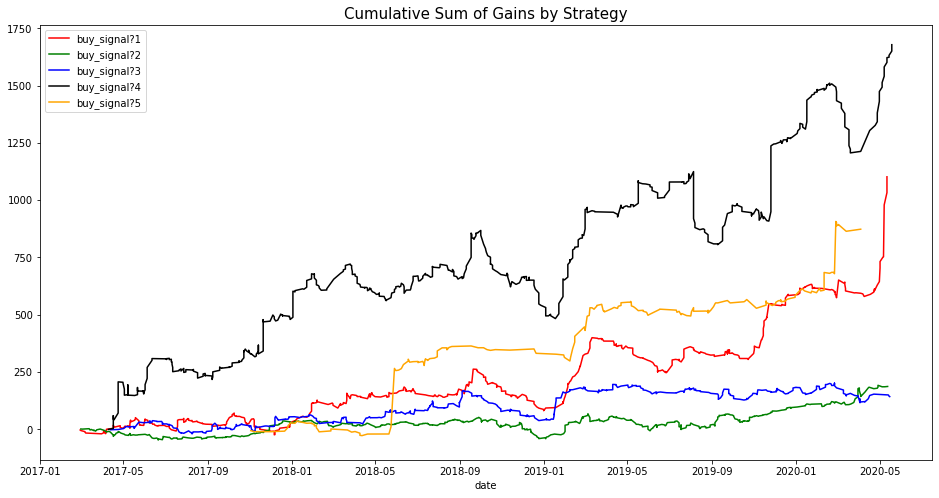

In [66]:
colors = ['red', 'green', 'blue', 'black', 'orange']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    rgl_df[rgl_df['strategy'] == signal[0]]['$_gain'].cumsum().plot(figsize=(16,8), color=colors[idx], label=signal[0])

plt.legend()
plt.title('Cumulative Sum of Gains by Strategy', size=15);

### Holdings

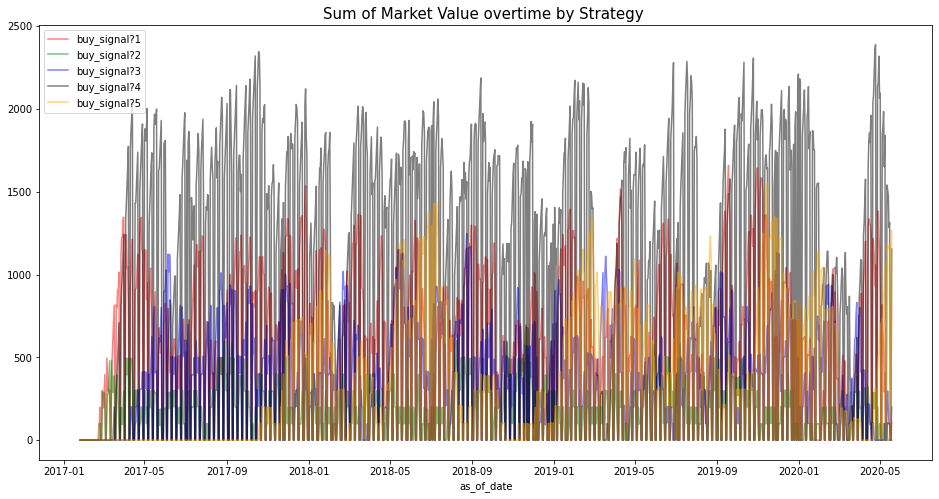

In [67]:
colors = ['red', 'green', 'blue', 'black', 'orange']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    holdings_df[holdings_df['strategy'] == signal[0]].groupby(level=0).sum()['market_value'].plot(figsize=(16,8), color=colors[idx], label=signal[0], alpha=0.5)

plt.legend()
plt.title('Sum of Market Value overtime by Strategy ', size=15);


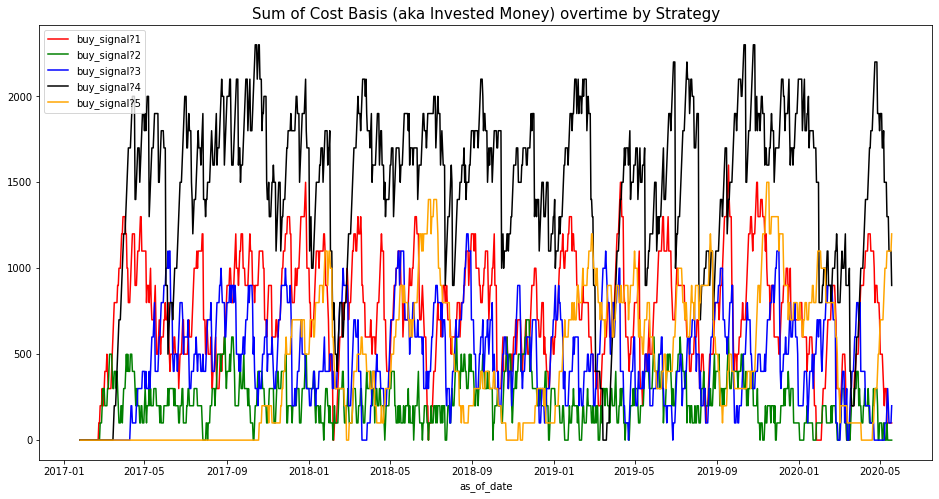

In [68]:
colors = ['red', 'green', 'blue', 'black', 'orange']

fig = plt.figure(figsize=(16,8))

for idx, signal in enumerate(pair_of_signals):
    holdings_df[holdings_df['strategy'] == signal[0]].groupby(level=0).sum()['cost_basis'].plot(figsize=(16,8), color=colors[idx], label=signal[0])

plt.legend()
plt.title('Sum of Cost Basis (aka Invested Money) overtime by Strategy', size=15);

In [69]:
holdings_df.tail(30)

,strategy,buy_date,symbol,cost_per_unit,shares,cost_basis,day_close_price,market_value,%_gain
as_of_date,,,,,,,,,
2020-05-18,buy_signal?2,0,0,0.000000,0.000000,0.0,NaN,NaN,NaN
2020-05-18,buy_signal?3,0,0,0.000000,0.000000,0.0,NaN,NaN,NaN
2020-05-18,buy_signal?3,0,0,0.000000,0.000000,0.0,NaN,NaN,NaN
2020-05-18,buy_signal?3,2020-05-15,BLK,512.659973,0.195061,100.0,517.065002,100.859250,0.008592
2020-05-18,buy_signal?4,0,0,0.000000,0.000000,0.0,NaN,NaN,NaN
2020-05-18,buy_signal?4,0,0,0.000000,0.000000,0.0,NaN,NaN,NaN
2020-05-18,buy_signal?4,2020-04-20,PRAA,25.980000,3.849115,100.0,34.020000,130.946886,0.309469
2020-05-18,buy_signal?4,2020-04-21,MBUU,25.600000,3.906250,100.0,46.290001,180.820313,0.808203
2020-05-18,buy_signal?4,2020-04-22,PRAA,24.200001,4.132231,100.0,34.020000,140.578510,0.405785
